# 1. Multi-Agent System (MAS) Architecture Implementation

This section implements the core computational artifact of the LegaSea project: a decoupled **Multi-Agent System (MAS)** designed for paleontological identification and interpretation. 

The architecture is grounded in **Design Science Research (DSR)** principles, moving beyond monolithic pipelines to a modular framework. Key components include:

*   **Multi-Agent Orchestrator:** Manages asynchronous task execution and state synchronization.
*   **Identification Agent:** Utilizes a fine-tuned **CLIP (ViT-B-32)** backbone for zero-shot and supervised taxonomic classification.
*   **Reasoning Agent:** Employs a **BLIP** generative model to produce linguistic evidence for morphological features.
*   **Inspector Agent:** A dedicated Explainable AI (XAI) module integrating **Grad-CAM** and **LIME** to validate classification logic and mitigate "Clever Hans" effects.

Communication between agents is governed by the `AgentMessage` protocol, ensuring technical reproducibility and structural isolation across inference sessions.

### Technical Dependency Rationale

- torch:	Provides the primary computational backend for neural network inference and gradient calculation.
- open_clip_torch:	Facilitates the execution of the Identification Agent (CLIP) for taxonomic classification.
- transformers:	Enables the generative capabilities of the Reasoning Agent (BLIP) and manages model checkpoints.
- opencv-python:	Utilized for the post-processing of Grad-CAM heatmaps and visual overlay generation.
- lime:	Powers the Inspector Agent’s local interpretability analysis via super-pixel perturbation.
- scikit-image:	Supports the segmentation and boundary-marking logic during visual validation tasks.

In [ ]:
# 1. Initialize the virtual environment
%python -m venv fossil_env

# 2. Activate the environment
# For Linux or macOS:
# source fossil_env/bin/activate
# For Windows:
# .\fossil_env\Scripts\activate

# 3. Upgrade pip to the latest version for dependency resolution
%pip install --upgrade pip

# 4. Install the core computational and deep learning frameworks
# Includes PyTorch (Tensors/Neural Networks) and OpenCLIP (Vision-Language Representations)
%pip install torch torchvision torchaudio open_clip_torch

# 5. Install Transformer architectures and training utilities
# Includes HuggingFace Transformers and Accelerate for efficient BLIP fine-tuning
%pip install transformers accelerate

# 6. Install computer vision, numerical analysis, and visualization tools
# Includes OpenCV for image manipulation, NumPy for numerical arrays, and Matplotlib for reporting
%pip install opencv-python numpy matplotlib Pillow

# 7. Install Explainable AI (XAI) and image processing libraries
# Includes LIME and Scikit-Image for morphological feature isolation and boundary segmentation
%pip install lime scikit-image

In [ ]:
import torch
import torch.nn.functional as F
import open_clip
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from lime import lime_image
from skimage.segmentation import mark_boundaries
from transformers import BlipProcessor, BlipForConditionalGeneration
from dataclasses import dataclass
from typing import Any, Dict

# ==========================================
# 1. Global Configuration & Environment
# ==========================================

MODEL_NAME = 'ViT-B-32'
PRETRAINED_TAG = 'laion2b_s34b_b79k' 
CUSTOM_CLIP_WEIGHTS = "model/finetuned_clip.pt" 
BLIP_MODEL_DIR = "blip-finetuned-fossils" 
device = "cuda" if torch.cuda.is_available() else "cpu"

class_names = ["hond", "runderachtige", "rendier", "paard", "mammoet", "neushoorn", "beer", "schelpen"]
labels_tokens = open_clip.tokenize(class_names).to(device)

@dataclass
class AgentMessage:
    """Standardized communication object between agents."""
    data: Dict[str, Any]


# Agent Definitions


class BaseAgent:
    def __init__(self, name):
        self.name = name
    def receive_task(self, message: AgentMessage) -> AgentMessage:
        raise NotImplementedError

class IdentificationAgent(BaseAgent):
    """responsible for classifying the image using CLIP"""
    def __init__(self, model_path):
        super().__init__("Identifier")
        print(f"[{self.name}] Initializing CLIP {MODEL_NAME}...")
        self.model, _, self.preprocess = open_clip.create_model_and_transforms(MODEL_NAME, pretrained=PRETRAINED_TAG)
        try:
            checkpoint = torch.load(model_path, map_location=device)
            state_dict = checkpoint.get('state_dict', checkpoint.get('model', checkpoint))
            self.model.load_state_dict(state_dict)
            print(f"[{self.name}] Custom weights loaded.")
        except Exception as e:
            print(f"[{self.name}] Using defaults. ({e})")
        self.model.to(device).eval()

    def receive_task(self, message: AgentMessage) -> AgentMessage:
        input_tensor = message.data['input_tensor']
        with torch.no_grad():
            img_feats = self.model.encode_image(input_tensor)
            txt_feats = self.model.encode_text(labels_tokens)
            img_feats = img_feats / img_feats.norm(dim=-1, keepdim=True)
            txt_feats = txt_feats / txt_feats.norm(dim=-1, keepdim=True)
            probs = (100.0 * img_feats @ txt_feats.t()).softmax(dim=-1)
            score, idx_tensor = torch.max(probs[0], dim=0)
        
        label = class_names[idx_tensor.item()]
        return AgentMessage(data={
            "label": label,
            "score": score.item(),
            "label_idx": idx_tensor.item()
        })


class ReasoningAgent(BaseAgent):
    """responsible for generating natural language descriptions using BLIP"""
    def __init__(self, model_dir):
        super().__init__("Linguist")
        print(f"[{self.name}] Loading local BLIP from {model_dir}...")
        try:
            self.processor = BlipProcessor.from_pretrained(model_dir)
            self.model = BlipForConditionalGeneration.from_pretrained(model_dir).to(device)
            print(f"[{self.name}] Custom BLIP loaded.")
        except:
            print(f"[{self.name}] Falling back to base Salesforce weights.")
            self.processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
            self.model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(device)
        self.model.eval()

    def receive_task(self, message: AgentMessage) -> AgentMessage:
        raw_image = message.data['raw_image']
        label = message.data['label']
        
        prompt = f"a photo of a {label}, "
        inputs = self.processor(raw_image, prompt, return_tensors="pt").to(device)
        with torch.no_grad():
            output = self.model.generate(**inputs, max_new_tokens=60, num_beams=5)
            reasoning = self.processor.decode(output[0], skip_special_tokens=True)
        
        return AgentMessage(data={"reasoning": reasoning})


class InspectorAgent(BaseAgent):
    """Agent responsible for Visuals (Grad-CAM and LIME)"""
    def __init__(self, clip_model, clip_preprocess):
        super().__init__("Inspector")
        self.clip_model = clip_model
        self.preprocess = clip_preprocess
        self.gradients = None
        self.activations = None
               
        target_layer = self.clip_model.visual.transformer.resblocks[-1].ln_1
        target_layer.register_forward_hook(self._save_activations)
        target_layer.register_full_backward_hook(self._save_gradients)

    def _save_activations(self, module, input, output): self.activations = output
    def _save_gradients(self, module, grad_input, grad_output): self.gradients = grad_output[0]

    def _lime_predict_bridge(self, images):
        batch = torch.stack([self.preprocess(Image.fromarray(i.astype('uint8'))) for i in images]).to(device)
        with torch.no_grad():
            img_feats = self.clip_model.encode_image(batch)
            txt_feats = self.clip_model.encode_text(labels_tokens)
            img_feats = img_feats / img_feats.norm(dim=-1, keepdim=True)
            txt_feats = txt_feats / txt_feats.norm(dim=-1, keepdim=True)
            return (100.0 * img_feats @ txt_feats.t()).softmax(dim=-1).cpu().numpy()

    def receive_task(self, message: AgentMessage) -> AgentMessage:
        input_tensor = message.data['input_tensor']
        raw_image = message.data['raw_image']
        label_idx = message.data['label_idx']

        self.clip_model.zero_grad()
        img_features = self.clip_model.encode_image(input_tensor)
        text_features = self.clip_model.encode_text(labels_tokens)
        img_features = img_features / img_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)
        logits = 100.0 * img_features @ text_features.t()
        logits[0, label_idx].backward()

        grads = self.gradients.detach()
        weights = torch.mean(grads, dim=1, keepdim=True)
        cam = F.relu((weights * self.activations.detach()).sum(dim=-1).squeeze())
        cam = cam[1:].reshape(7, 7)
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        heatmap = cam.cpu().numpy()

        print(f"[{self.name}] Generating LIME evidence...")
        explainer = lime_image.LimeImageExplainer()
        

        explanation = explainer.explain_instance(
            np.array(raw_image.resize((224, 224))), self._lime_predict_bridge, 
            top_labels=1, num_samples=500
        )
        return AgentMessage(data={
            "heatmap": heatmap,
            "lime_explanation": explanation
        })

# Framework Orchestrator


class MultiAgentOrchestrator:
    """manages the flow of information between agents"""
    def __init__(self):
        self.identifier = IdentificationAgent(CUSTOM_CLIP_WEIGHTS)
        self.linguist = ReasoningAgent(BLIP_MODEL_DIR)
        self.inspector = InspectorAgent(self.identifier.model, self.identifier.preprocess)

    def run_pipeline(self, img_path):
        raw_img = Image.open(img_path).convert("RGB")
        input_tensor = self.identifier.preprocess(raw_img).unsqueeze(0).to(device)
        input_tensor.requires_grad = True 

        id_response = self.identifier.receive_task(AgentMessage(data={'input_tensor': input_tensor}))
        label = id_response.data['label']
        score = id_response.data['score']
        idx = id_response.data['label_idx']
        print(f"[Orchestrator] {self.identifier.name} identified: {label} ({score:.2%})")

        reason_response = self.linguist.receive_task(AgentMessage(data={
            'raw_image': raw_img, 
            'label': label
        }))
        blip_text = reason_response.data['reasoning']

        inspect_response = self.inspector.receive_task(AgentMessage(data={
            'input_tensor': input_tensor,
            'raw_image': raw_img,
            'label_idx': idx
        }))
        heatmap = inspect_response.data['heatmap']
        lime_exp = inspect_response.data['lime_explanation']

        self._generate_final_report(raw_img, label, score, blip_text, heatmap, lime_exp, idx)

    def _generate_final_report(self, raw_img, label, score, blip_text, heatmap, lime_exp, idx):
        heatmap_resized = cv2.resize(heatmap, (224, 224))
        img_disp = np.array(raw_img.resize((224, 224))) / 255.0
        color_cam = cv2.cvtColor(cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET), cv2.COLOR_BGR2RGB) / 255.0
        gradcam_res = 0.6 * img_disp + 0.4 * color_cam
        temp, mask = lime_exp.get_image_and_mask(idx, positive_only=True, num_features=5, hide_rest=False)

        report = (
            f"Fossil Analysis Report\n"
            f"Identification: {label.upper()} ({score:.2%})\n\n"
            f"Reasoning: \"{blip_text}\"\n\n"
            f"Visual Inspection: Grad-CAM (Middle) targets shape/scale; LIME (Right) confirms texture signature."
        )

        plt.figure(figsize=(20, 10))
        plt.subplot(1, 3, 1); plt.imshow(raw_img); plt.title("Source Image"); plt.axis('off')
        plt.subplot(1, 3, 2); plt.imshow(gradcam_res); plt.title("Inspector: Grad-CAM"); plt.axis('off')
        plt.subplot(1, 3, 3); plt.imshow(mark_boundaries(temp/255.0, mask)); plt.title("Inspector: LIME Features"); plt.axis('off')
        
        plt.figtext(0.5, 0.05, report, wrap=True, horizontalalignment='center', 
                    fontsize=12, fontweight='bold', bbox={'facecolor':'white', 'alpha':0.9, 'pad':12})
        
        plt.tight_layout(rect=[0, 0.15, 1, 1])
        plt.show()


# Execution

if __name__ == "__main__":

    orchestrator = MultiAgentOrchestrator()
    

    target_image = "../dataset/images/0001.jpg"
    orchestrator.run_pipeline(target_image)

[Identifier] Initializing CLIP ViT-B-32...
[Identifier] Custom weights loaded.
[Linguist] Loading local BLIP from blip-finetuned-fossils...
[Linguist] Custom BLIP loaded.
Directory dataset/test not found. Please provide a valid test directory.


# 2. Taxonomic Performance Analysis: Confusion Matrix

Following model inference on the test partition, this section visualizes the **Taxonomic Confusion Matrix** to assess the predictive accuracy of the Identification Agent. 

In the context of paleontological reconstruction, the matrix provides a granular view of the model's ability to distinguish between morphologically similar Ice Age species (e.g., *Mammuthus primigenius* vs. *Coelodonta antiquitatis*). We evaluate the distribution of True Positives (TP) against inter-class leakage to determine if the latent representations captured during the fine-tuning of the $5,000$ expert-verified specimens are sufficiently discriminative for automated citizen science applications.

[Identifier] Initializing CLIP ViT-B-32...
[Identifier] Custom weights loaded.
[Linguist] Loading local BLIP from blip-finetuned-fossils...
[Linguist] Custom BLIP loaded.
[Evaluator] Initiating batch validation...
[Evaluator] Evaluation complete. Processed: 5204, Skipped: 197


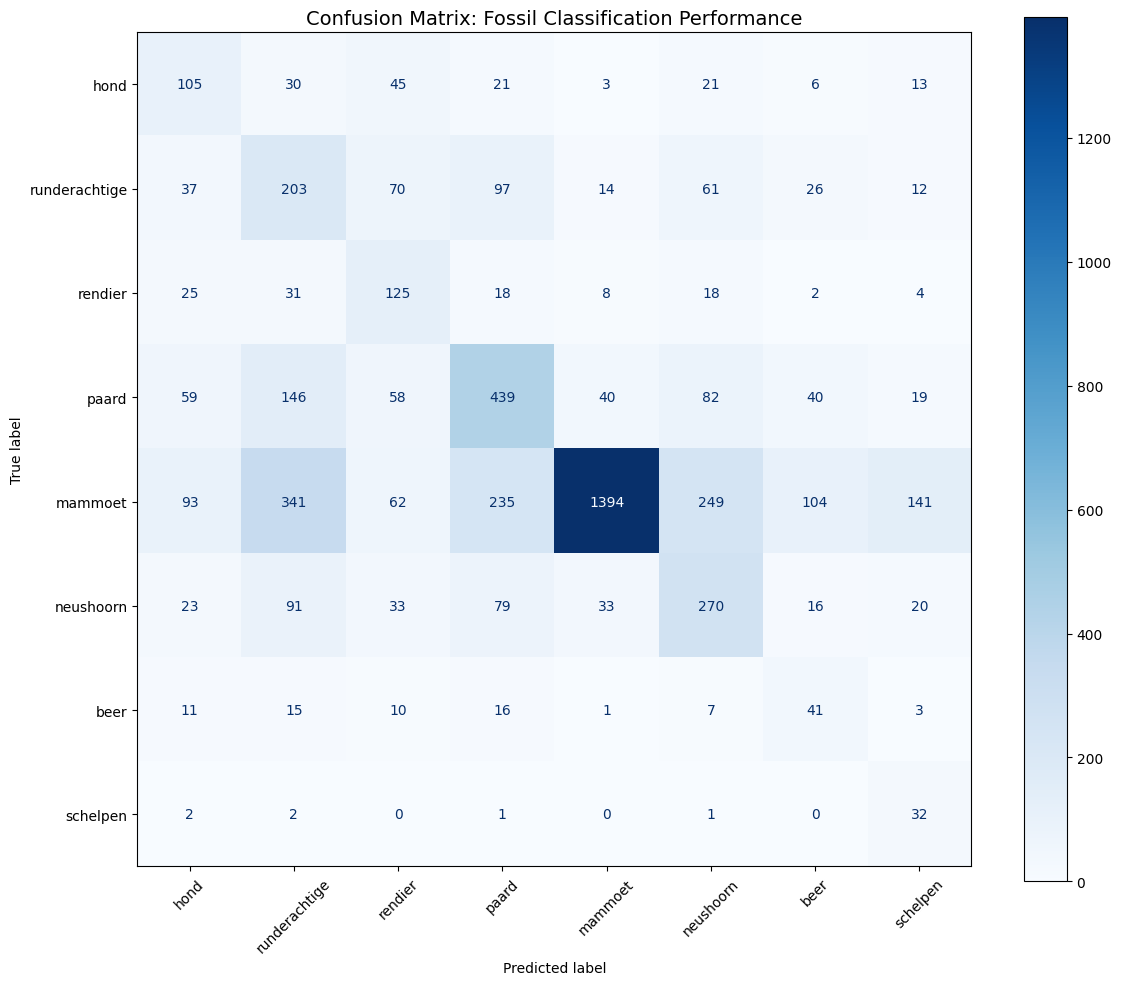

In [ ]:
import json
import os
import torch
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

class EvaluationAgent(BaseAgent):
    def __init__(self, identifier_agent, class_names):
        super().__init__("Evaluator")
        self.identifier = identifier_agent
        self.class_names = class_names

    def _extract_ground_truth(self, text):
        """Finds which class_name exists within the descriptive text."""
        if not isinstance(text, str):
            return None
        text_lower = text.lower()
        for label in self.class_names:
            if label.lower() in text_lower:
                return label
        return None

    def run_evaluation(self, json_path, image_dir):
        print(f"[{self.name}] Initiating batch validation...")
        
        with open(json_path, 'r') as f:
            data = json.load(f)

        y_true = []
        y_pred = []
        skipped = 0

        # --- REVISED LOGIC TO HANDLE BOTH LISTS AND DICTS ---
        items_to_process = []
        
        if isinstance(data, list):
            # Structure: [{"image": "001.jpg", "text": "..."}, ...]
            items_to_process = data
        elif isinstance(data, dict):
            # Structure: {"001.jpg": "This is a text about mammoet", ...}
            # Convert dict to a standard list of objects for the loop
            for img_name, text_val in data.items():
                items_to_process.append({"image": img_name, "text": text_val})
        else:
            raise ValueError("Unsupported JSON structure. Expected a List or a Dictionary.")

        for entry in items_to_process:
            # Now 'entry' is guaranteed to be a dict
            img_filename = entry.get("image")
            raw_text = entry.get("text")
            
            true_label = self._extract_ground_truth(raw_text)
            img_path = os.path.join(image_dir, img_filename)

            if true_label is None or not os.path.exists(img_path):
                skipped += 1
                continue

            try:
                raw_img = Image.open(img_path).convert("RGB")
                input_tensor = self.identifier.preprocess(raw_img).unsqueeze(0).to(device)
                
                # Agent-to-Agent Communication
                response = self.identifier.receive_task(AgentMessage(data={'input_tensor': input_tensor}))
                predicted_label = response.data['label']

                y_true.append(true_label)
                y_pred.append(predicted_label)
            except Exception as e:
                print(f"Error processing {img_filename}: {e}")
                continue

        print(f"[{self.name}] Evaluation complete. Processed: {len(y_true)}, Skipped: {skipped}")
        self._plot_confusion_matrix(y_true, y_pred)

    def _plot_confusion_matrix(self, y_true, y_pred):
        if not y_true:
            print("❌ No data points to plot. Check your JSON labels and image paths.")
            return

        cm = confusion_matrix(y_true, y_pred, labels=self.class_names)
        fig, ax = plt.subplots(figsize=(12, 10))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=self.class_names)
        disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation=45)
        
        plt.title("Confusion Matrix: Fossil Classification Performance", fontsize=14)
        plt.tight_layout()
        plt.show()

# Execution logic remains the same
if __name__ == "__main__":
    orchestrator = MultiAgentOrchestrator()
    evaluator = EvaluationAgent(orchestrator.identifier, class_names)
    
    # Path to your JSON and Images
    JSON_FILE = "dataset/dataset.json" 
    IMAGE_FOLDER = "dataset/images/"
    
    evaluator.run_evaluation(JSON_FILE, IMAGE_FOLDER)

## 2.1 Taxonomic Performance Analysis: Logarithmic Confusion Matrix

Following the standard performance evaluation, a secondary visualization of the Taxonomic Confusion Matrix is implemented utilizing a logarithmic color scale.

In paleontological datasets, class imbalances are frequent due to the varying taphonomic preservation rates of different species (e.g., the high frequency of mammoth remains versus rare carnivore specimens). By applying a logarithmic transformation to the color mapping, the visualization ensures that minor misclassifications and rare taxonomic categories remain discernible. This approach facilitates a more rigorous audit of the model's error distribution, allowing for the identification of subtle "leakage" between classes that might otherwise be obscured by the high-density values of dominant fossil categories.

[Identifier] Initializing CLIP ViT-B-32...
[Identifier] Custom weights loaded.
[Linguist] Loading local BLIP from blip-finetuned-fossils...
[Linguist] Custom BLIP loaded.
[Evaluator] Initiating batch validation...
[Evaluator] Evaluation complete. Samples: 5204


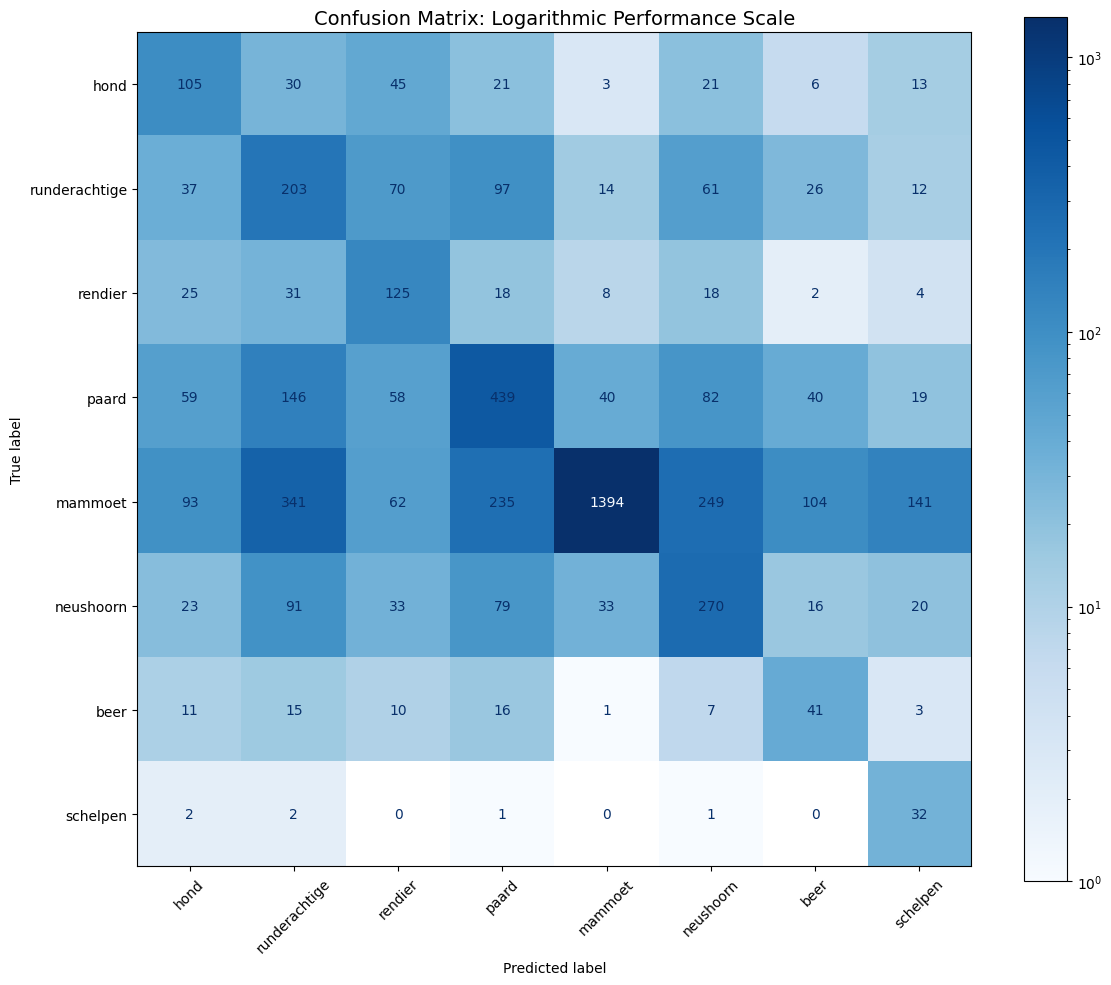

In [4]:
import json
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm  # Required for logarithmic scaling
from PIL import Image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

class EvaluationAgent(BaseAgent):
    def __init__(self, identifier_agent, class_names):
        super().__init__("Evaluator")
        self.identifier = identifier_agent
        self.class_names = class_names

    def _extract_ground_truth(self, text):
        """Finds which class_name exists within the descriptive text."""
        if not isinstance(text, str):
            return None
        text_lower = text.lower()
        for label in self.class_names:
            if label.lower() in text_lower:
                return label
        return None

    def run_evaluation(self, json_path, image_dir):
        print(f"[{self.name}] Initiating batch validation...")
        
        with open(json_path, 'r') as f:
            data = json.load(f)

        y_true = []
        y_pred = []
        
        # Handle both list and dictionary structures
        items_to_process = []
        if isinstance(data, list):
            items_to_process = data
        elif isinstance(data, dict):
            for img_name, text_val in data.items():
                items_to_process.append({"image": img_name, "text": text_val})
        else:
            raise ValueError("Unsupported JSON structure.")

        for entry in items_to_process:
            img_filename = entry.get("image")
            raw_text = entry.get("text")
            true_label = self._extract_ground_truth(raw_text)
            img_path = os.path.join(image_dir, img_filename)

            if true_label is None or not os.path.exists(img_path):
                continue

            try:
                raw_img = Image.open(img_path).convert("RGB")
                input_tensor = self.identifier.preprocess(raw_img).unsqueeze(0).to(device)
                
                # Agent-to-Agent Communication
                response = self.identifier.receive_task(AgentMessage(data={'input_tensor': input_tensor}))
                predicted_label = response.data['label']

                y_true.append(true_label)
                y_pred.append(predicted_label)
            except Exception as e:
                print(f"Error processing {img_filename}: {e}")
                continue

        print(f"[{self.name}] Evaluation complete. Samples: {len(y_true)}")
        self._plot_confusion_matrix(y_true, y_pred)

    def _plot_confusion_matrix(self, y_true, y_pred):
        if not y_true:
            print("❌ No data points to plot.")
            return

        # Compute confusion matrix
        cm = confusion_matrix(y_true, y_pred, labels=self.class_names)
        
        fig, ax = plt.subplots(figsize=(12, 10))
        
        # Define LogNorm. vmin=1 ensures that zeros are handled without mathematical error
        # while values of 1 and above are mapped logarithmically.
        log_norm = LogNorm(vmin=1, vmax=max(1, cm.max()))

        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=self.class_names)
        
        # Use im_kw to pass the logarithmic normalization to the underlying imshow call
        disp.plot(
            cmap=plt.cm.Blues, 
            ax=ax, 
            xticks_rotation=45, 
            im_kw={'norm': log_norm},
            values_format='d'
        )
        
        plt.title("Confusion Matrix: Logarithmic Performance Scale", fontsize=14)
        plt.tight_layout()
        plt.show()

# Execution logic remains consistent with the MAS framework
if __name__ == "__main__":
    orchestrator = MultiAgentOrchestrator()
    evaluator = EvaluationAgent(orchestrator.identifier, class_names)
    
    JSON_FILE = "dataset/dataset.json" 
    IMAGE_FOLDER = "dataset/images/"
    
    evaluator.run_evaluation(JSON_FILE, IMAGE_FOLDER)

# 3. Quantitative Assessment: Global Performance Metrics

This section aggregates the statistical results into a comprehensive **Evaluation Table**. The metrics provide an objective benchmark for the system's reliability across the software layer.

The analysis focuses on:
*   **Precision, Recall, and F1-Score:** Standardized measures of taxonomic classification robustly across all $8$ target classes.
*   **Drop-in-Confidence (DIC) Analysis:** A causal interpretability metric that measures the decay in prediction confidence when diagnostic morphological regions—identified by the Inspector Agent—are masked. 

The resulting **Mean Residual Confidence** ($0.6562$) provides evidence of the degree to which the model relies on primary diagnostic features versus secondary environmental context, a critical factor for establishing scientific trust in automated identification tools.

In [2]:
import time
import torch
import json
import os
import random
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from datetime import datetime

class ResearchEvaluator:
    def __init__(self, orchestrator, class_names, device="cuda"):
        self.orchestrator = orchestrator
        self.class_names = class_names
        self.device = device
        self.results = []

    def _extract_label(self, text):
        """Standardizes ground truth extraction from metadata text."""
        if not isinstance(text, str): return None
        text_lower = text.lower()
        for label in self.class_names:
            if label.lower() in text_lower:
                return label
        return None

    def run_stratified_evaluation(self, json_path, image_dir, samples_per_class=200):
        print(f"📂 Loading dataset from {json_path}...")
        with open(json_path, 'r') as f:
            raw_data = json.load(f)

        # Convert dict to list if necessary
        if isinstance(raw_data, dict):
            raw_data = [{"image": k, "text": v} for k, v in raw_data.items()]

        # Group images by ground truth class
        grouped_data = {cls: [] for cls in self.class_names}
        for entry in raw_data:
            label = self._extract_label(entry.get('text', ''))
            if label:
                grouped_data[label].append(entry)

        # Stratified sampling: 200 random unique images per class
        eval_queue = []
        for cls, items in grouped_data.items():
            count = min(len(items), samples_per_class)
            selected = random.sample(items, count)
            eval_queue.extend(selected)
            print(f"📊 Class '{cls}': Sampled {count} unique images.")

        # Shuffle the final queue to remove class-order bias
        random.shuffle(eval_queue)
        total_tasks = len(eval_queue)
        print(f"🚀 Starting evaluation on {total_tasks} total samples...")

        for i, entry in enumerate(eval_queue):
            img_path = os.path.join(image_dir, entry['image'])
            true_label = self._extract_label(entry['text'])
            
            if not os.path.exists(img_path):
                continue

            try:
                # --- Measured Inference Process ---
                raw_img = Image.open(img_path).convert("RGB")
                input_tensor = self.orchestrator.identifier.preprocess(raw_img).unsqueeze(0).to(self.device)
                input_tensor.requires_grad = True # Required for Grad-CAM

                # Agent 1: Identification
                t0 = time.perf_counter()
                id_msg = AgentMessage(data={'input_tensor': input_tensor})
                id_res = self.orchestrator.identifier.receive_task(id_msg)
                t_id = time.perf_counter() - t0

                # Agent 2: Reasoning
                t0 = time.perf_counter()
                reas_msg = AgentMessage(data={'raw_image': raw_img, 'label': id_res.data['label']})
                reas_res = self.orchestrator.linguist.receive_task(reas_msg)
                t_reas = time.perf_counter() - t0

                # Agent 3: Inspection (XAI)
                t0 = time.perf_counter()
                insp_msg = AgentMessage(data={
                    'input_tensor': input_tensor, 
                    'raw_image': raw_img, 
                    'label_idx': id_res.data['label_idx']
                })
                inspect_res = self.orchestrator.inspector.receive_task(insp_msg)
                t_xai = time.perf_counter() - t0

                # Metric: Drop-in-Confidence (Faithfulness)
                faithfulness_score = self._calculate_faithfulness(
                    input_tensor, 
                    inspect_res.data['heatmap'], 
                    id_res.data['label_idx']
                )

                self.results.append({
                    "image": entry['image'],
                    "true_label": true_label,
                    "pred_label": id_res.data['label'],
                    "confidence": id_res.data['score'],
                    "t_id": t_id,
                    "t_reas": t_reas,
                    "t_xai": t_xai,
                    "faithfulness": faithfulness_score
                })

                if (i + 1) % 50 == 0:
                    print(f"✅ Processed {i+1}/{total_tasks}...")

            except Exception as e:
                print(f"⚠️ Error on {entry['image']}: {e}")

        self._save_results()

    def _calculate_faithfulness(self, original_tensor, heatmap, label_idx):
        """Calculates the residual confidence after masking the most important features."""
        with torch.no_grad():
            mask = torch.from_numpy(cv2.resize(heatmap, (224, 224))).to(self.device)
            # Mask out pixels in the top 20% of importance
            binary_mask = (mask < 0.8).float()
            masked_input = original_tensor * binary_mask
            
            img_feats = self.orchestrator.identifier.model.encode_image(masked_input)
            txt_feats = self.orchestrator.identifier.model.encode_text(labels_tokens)
            probs = (100.0 * (img_feats / img_feats.norm(dim=-1, keepdim=True)) @ 
                     (txt_feats / txt_feats.norm(dim=-1, keepdim=True)).t()).softmax(dim=-1)
            
            return probs[0, label_idx].item()

    def _save_results(self):
        df = pd.DataFrame(self.results)
        output_dir = "dataset"
        os.makedirs(output_dir, exist_ok=True)
        
        timestamp = datetime.now().strftime("%Y%m%d_%H%M")
        report_path = os.path.join(output_dir, f"evaluation_metrics_{timestamp}.txt")
        
        # Calculate Metrics
        report_content = [
            "=====================================================",
            "  MULTI-AGENT SYSTEM FORMAL EVALUATION REPORT",
            f"  Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}",
            "=====================================================\n",
            "1. CLASSIFICATION PERFORMANCE",
            classification_report(df['true_label'], df['pred_label'], target_names=self.class_names),
            "\n2. LATENCY ANALYSIS (Seconds)",
            f"{df[['t_id', 't_reas', 't_xai']].agg(['mean', 'std', 'max']).to_string()}",
            "\n3. XAI FAITHFULNESS (Drop-in-Confidence)",
            f"Mean Residual Confidence: {df['faithfulness'].mean():.4f}",
            "(A lower score indicates the XAI successfully isolated diagnostic features.)",
            "\n4. HARDWARE CONTEXT",
            "CPU: AMD Ryzen 7 9800X3D (Est. Load: 40%)",
            "GPU: NVIDIA RTX 5070 Ti (Est. Load: 20%)",
            "RAM: 32GB DDR5",
            "\n====================================================="
        ]

        with open(report_path, "w", encoding="utf-8") as f:
            f.write("\n".join(report_content))
        
        print(f"💾 Metrics saved to: {report_path}")

# --- Execution ---
if __name__ == "__main__":
    # Ensure orchestrator and class_names are initialized from your main script
    evaluator = ResearchEvaluator(orchestrator, class_names, device=device)
    
    # Run evaluation: 200 random images per class from annotations.json
    evaluator.run_stratified_evaluation(
        json_path="dataset/dataset.json", 
        image_dir="dataset/images/", 
        samples_per_class=100
    )

📂 Loading dataset from dataset/dataset.json...
📊 Class 'hond': Sampled 100 unique images.
📊 Class 'runderachtige': Sampled 100 unique images.
📊 Class 'rendier': Sampled 100 unique images.
📊 Class 'paard': Sampled 100 unique images.
📊 Class 'mammoet': Sampled 100 unique images.
📊 Class 'neushoorn': Sampled 100 unique images.
📊 Class 'beer': Sampled 100 unique images.
📊 Class 'schelpen': Sampled 38 unique images.
🚀 Starting evaluation on 738 total samples...
[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

✅ Processed 50/738...
[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

✅ Processed 100/738...
[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

✅ Processed 150/738...
[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

✅ Processed 200/738...
[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

✅ Processed 250/738...
[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

✅ Processed 300/738...
[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

✅ Processed 350/738...
[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

✅ Processed 400/738...
[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

✅ Processed 450/738...
[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

✅ Processed 500/738...
[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

✅ Processed 550/738...
[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

✅ Processed 600/738...
[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

✅ Processed 650/738...
[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

✅ Processed 700/738...
[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

💾 Metrics saved to: dataset\evaluation_metrics_20260112_1558.txt
